In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 500000
D = 20
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(3.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    #encoder_function=lambda x: x, decoder_function=lambda x: x,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=100, rel_tol=1e-3, learning_rate=.1)



W0518 17:04:27.782273 4376473024 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 142.62772094401356
Epoch 1: average-batch loss: 38.50494986931048 last batch loss: 36.47885896276236
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 36.16737688838779 last batch loss: 36.21029127374769
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 35.965853864318966 last batch loss: 36.01516588866255
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 35.81943345077263 last batch loss: 35.92413782079286
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 35.73735598886164 last batch loss: 35.864351501785
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 35.69322260217281 last batch loss: 35.82854624719887
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 35.671796992488694 last batch loss: 35.81635091980713
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 35.64756107113771 last batch loss: 35.79602818855063
Saved a checkpoint: ./.tf_ckpts

Epoch 77: average-batch loss: 35.6210806406737 last batch loss: 35.77538417108164
We are in a loss plateau learning rate: 2.384185791015625e-08 loss: 35.52408340560547
Restoring from a checkpoint - loss: 35.530065187883494
Epoch 78: average-batch loss: 35.622049144579165 last batch loss: 35.78724955696688
Epoch 79: average-batch loss: 35.62646002180607 last batch loss: 35.78121941570293
Epoch 80: average-batch loss: 35.62355959865877 last batch loss: 35.75472765228401
Epoch 81: average-batch loss: 35.61689924419366 last batch loss: 35.778702084529925
Epoch 82: average-batch loss: 35.63252879097576 last batch loss: 35.767293391494256
We are in a loss plateau learning rate: 5.960464477539063e-09 loss: 35.51676093052832
Restoring from a checkpoint - loss: 35.516748353818286
Epoch 83: average-batch loss: 35.61912074990104 last batch loss: 35.78509813621631
Epoch 84: average-batch loss: 35.616845893739054 last batch loss: 35.766701362993004
Epoch 85: average-batch loss: 35.615886223299846 l

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 692877.5686280312, 'se': 3242.5635193932762, 'lppd': -52401.67686144534, 'pwaic': 294037.1074525702}


# Plot the factor encoding matrix

In [7]:
intercept_data = az.convert_to_inference_data({r"$w_d$": tf.squeeze(factor.surrogate_distribution.sample(1000)['w']).numpy().T})

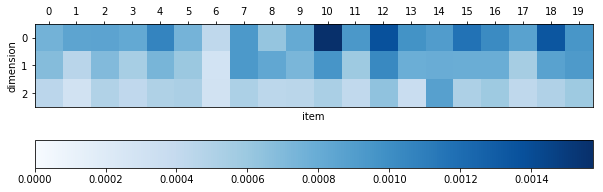

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


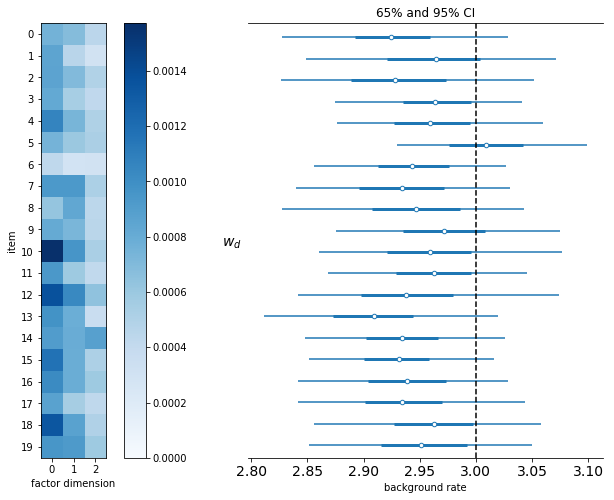

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy(), vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(3.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.